# Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import re
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\iampr\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\iampr\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# Dataset-1

In [2]:
df1=pd.read_csv("imdb_master.csv",encoding='latin')
df1.head()

,Unnamed: 0,type,review,label,file
0,0,test,Once again Mr. Costner has dragged out a movie...,neg,0_2.txt
1,1,test,This is an example of why the majority of acti...,neg,10000_4.txt
2,2,test,"First of all I hate those moronic rappers, who...",neg,10001_1.txt
3,3,test,Not even the Beatles could write songs everyon...,neg,10002_3.txt
4,4,test,Brass pictures (movies is not a fitting word f...,neg,10003_3.txt


In [3]:
df1.drop(['Unnamed: 0','type','file'],axis=1,inplace=True)
df1 = df1[df1.label != 'unsup']
df1['label'] = df1['label'].map({'pos': 1, 'neg': 0})
df1.head()

,review,label
0,Once again Mr. Costner has dragged out a movie...,0
1,This is an example of why the majority of acti...,0
2,"First of all I hate those moronic rappers, who...",0
3,Not even the Beatles could write songs everyon...,0
4,Brass pictures (movies is not a fitting word f...,0


In [4]:
unique, counts = np.unique(df1.label, return_counts=True)
dict(zip(unique, counts))

{0: 25000, 1: 25000}

In [5]:
df1.columns=['review','sentiment']
df1.head()

,review,sentiment
0,Once again Mr. Costner has dragged out a movie...,0
1,This is an example of why the majority of acti...,0
2,"First of all I hate those moronic rappers, who...",0
3,Not even the Beatles could write songs everyon...,0
4,Brass pictures (movies is not a fitting word f...,0


# Dataset-2

In [6]:
df2 = pd.read_csv('labeledTrainData.tsv', delimiter="\t")
df2.head()

,id,sentiment,review
0,5814_8,1,With all this stuff going down at the moment w...
1,2381_9,1,"\The Classic War of the Worlds\"" by Timothy Hi..."
2,7759_3,0,The film starts with a manager (Nicholas Bell)...
3,3630_4,0,It must be assumed that those who praised this...
4,9495_8,1,Superbly trashy and wondrously unpretentious 8...


In [7]:
df2 = df2.drop(['id'], axis=1)
df2.head()

,sentiment,review
0,1,With all this stuff going down at the moment w...
1,1,"\The Classic War of the Worlds\"" by Timothy Hi..."
2,0,The film starts with a manager (Nicholas Bell)...
3,0,It must be assumed that those who praised this...
4,1,Superbly trashy and wondrously unpretentious 8...


In [8]:
unique, counts = np.unique(df2.sentiment, return_counts=True)
dict(zip(unique, counts))

{0: 12500, 1: 12500}

# Concatenation Dataset

In [9]:
df = pd.concat([df1, df2]).reset_index(drop=True)
df.head()

,review,sentiment
0,Once again Mr. Costner has dragged out a movie...,0
1,This is an example of why the majority of acti...,0
2,"First of all I hate those moronic rappers, who...",0
3,Not even the Beatles could write songs everyon...,0
4,Brass pictures (movies is not a fitting word f...,0


In [10]:
unique, counts = np.unique(df.sentiment, return_counts=True)
dict(zip(unique, counts))

{0: 37500, 1: 37500}

# Text Preprossesing

In [11]:
stop_words = set(stopwords.words("english")) 
lemmatizer = WordNetLemmatizer()


def clean_text(text):
    text = text.lower()
    text = text = re.sub("[^a-z]+", " ", text)
    text = [lemmatizer.lemmatize(token) for token in text.split(" ")]
    text = [lemmatizer.lemmatize(token, "v") for token in text]
    text = [word for word in text if not word in stop_words]
    text = " ".join(text)
    return text

df['Processed_Reviews'] = df.review.apply(lambda x: clean_text(x))   # df.review.map(clean_text) Also can be used


In [12]:
df.head()

,review,sentiment,Processed_Reviews
0,Once again Mr. Costner has dragged out a movie...,0,mr costner ha drag movie far longer necessary ...
1,This is an example of why the majority of acti...,0,example majority action film generic bore real...
2,"First of all I hate those moronic rappers, who...",0,first hate moronic rapper could nt act gun pre...
3,Not even the Beatles could write songs everyon...,0,even beatles could write song everyone like al...
4,Brass pictures (movies is not a fitting word f...,0,brass picture movie fit word really somewhat b...


# Model Building

In [13]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense , Input , GRU , Embedding, Dropout , Activation, Flatten
from keras.layers import GlobalMaxPool1D
from keras.models import Model, Sequential

Using TensorFlow backend.


In [14]:
x=df.Processed_Reviews
y=df.sentiment

In [15]:
num_words = 10000
embed_dim = 64
tokenizer = Tokenizer(num_words=num_words,oov_token = "<oov>" )
tokenizer.fit_on_texts(x)
word_index=tokenizer.word_index

In [16]:
sequences = tokenizer.texts_to_sequences(x)

In [17]:
length=[]
for i in sequences:
    length.append(len(i))
print(len(length))
print("Mean is: ",np.mean(length))
print("Max is: ",np.max(length))
print("Min is: ",np.min(length))

75000
Mean is:  125.32908
Max is:  1457
Min is:  3


In [18]:
pad_length = 130
sequences = pad_sequences(sequences, maxlen = pad_length, truncating = 'pre', padding = 'post')

In [19]:
from sklearn.model_selection import train_test_split as tts

In [20]:
x_train, x_test, y_train, y_test = tts(sequences, y, test_size = 0.04)
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(72000, 130)
(3000, 130)
(72000,)
(3000,)


In [21]:
unique, counts = np.unique(y_train, return_counts=True)
dict(zip(unique, counts))

{0: 36017, 1: 35983}

In [22]:
model = Sequential([Embedding(num_words, embed_dim, input_length = pad_length),
                   GRU(64, return_sequences = True),
                   GlobalMaxPool1D(),
                   Dense(64,activation = 'relu',kernel_initializer='he_uniform'),
                   Dropout(0.25),
                   Dense(1,activation = 'sigmoid')])
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.name = 'IMDB Sentiment Analysis'
model.summary()

Model: "IMDB Sentiment Analysis"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 130, 64)           640000    
_________________________________________________________________
gru_1 (GRU)                  (None, 130, 64)           24768     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 668,993
Trainable params: 668,993
Non-trainable params: 0
_____________________________________

In [23]:
history = model.fit(x= x_train, y= y_train, batch_size= 64, epochs=5, validation_split = 0.04)

C:\Users\iampr\anaconda3\envs\tensorflow\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 69120 samples, validate on 2880 samples
Epoch 1/5
69120/69120 [==============================] - 347s 5ms/step - loss: 0.3175 - accuracy: 0.8640 - val_loss: 0.2416 - val_accuracy: 0.9017
Epoch 2/5
69120/69120 [==============================] - 342s 5ms/step - loss: 0.1826 - accuracy: 0.9329 - val_loss: 0.2117 - val_accuracy: 0.9187
Epoch 3/5
69120/69120 [==============================] - 339s 5ms/step - loss: 0.1145 - accuracy: 0.9614 - val_loss: 0.1836 - val_accuracy: 0.9389
Epoch 4/5
69120/69120 [==============================] - 339s 5ms/step - loss: 0.0609 - accuracy: 0.9809 - val_loss: 0.1892 - val_accuracy: 0.9410
Epoch 5/5
69120/69120 [==============================] - 215s 3ms/step - loss: 0.0321 - accuracy: 0.9908 - val_loss: 0.2232 - val_accuracy: 0.9438


In [24]:
test_stats = model.evaluate(x_test,y_test)
print("Test Accuracy is : {:.2f}".format(test_stats[1]*100))

3000/3000 [==============================] - 3s 900us/step
Test Accuracy is : 93.13


In [25]:
train_acc = history.history['accuracy']
valid_acc = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

In [26]:
import matplotlib
from matplotlib import pyplot as plt

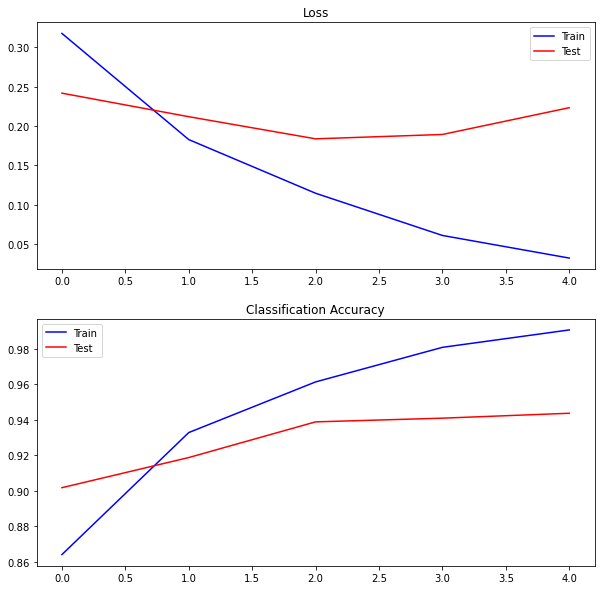

In [32]:
fig=plt.figure(figsize=(10,10))
fig.add_subplot(2, 1, 1)
plt.title('Loss')
plt.plot(train_loss, color='blue', label='Train')
plt.plot(val_loss, color='red', label='Test')
plt.legend()
# plot accuracy
fig.add_subplot(2, 1, 2)
plt.title('Classification Accuracy')
plt.plot(train_acc, color='blue', label='Train')
plt.plot(valid_acc, color='red', label='Test')
plt.legend()

In [33]:
model.save('IMDBSentimentAnalysis')